In [11]:
import torch
import torch.nn as nn
import pandas as pd
import torch.utils.data as data
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [12]:
def assign_interval(value):
    if value <= 100000:
        return 0
    elif value <= 350000:
        return 1
    else:
        return 2

In [45]:
class MNISTClassifier_Dropout(nn.Module):
    def __init__(self):
        super(MNISTClassifier_Dropout, self).__init__()
        self.layer1 = nn.Linear(23, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.act1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)

        self.layer2 = nn.Linear(256, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.act2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.5)

        self.layer3 = nn.Linear(256, 3)

    def forward(self, x):
        x = self.act1(self.bn1(self.layer1(x)))
        x = self.dropout1(x)

        x = self.act2(self.bn2(self.layer2(x)))
        x = self.dropout2(x)

        x = self.layer3(x)
        return x

In [39]:
train_data = pd.read_csv('train_data.csv')

le = LabelEncoder()
train_data['TimeToBusStop'] = le.fit_transform(train_data['TimeToBusStop'])
train_data['TimeToSubway'] = le.fit_transform(train_data['TimeToSubway'])

ohe_cols = ['HallwayType', 'HeatingType', 'AptManageType', 'SubwayStation']
train_data = pd.get_dummies(train_data, columns=ohe_cols, drop_first=True).astype(float)

train_data['SalePrice'] = train_data['SalePrice'].apply(assign_interval)

In [40]:
X = train_data.drop('SalePrice', axis=1).values
y = train_data['SalePrice'].values

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

dataset = data.TensorDataset(torch.tensor(X_scaled).float(), torch.tensor(y).long())

In [41]:
train_indices, test_indices = train_test_split(list(range(len(dataset))), test_size=0.2, random_state=42)
train_dataset = data.Subset(dataset, train_indices)
test_dataset = data.Subset(dataset, test_indices)

train_labels = torch.tensor(y[train_indices]).long()
class_counts = torch.bincount(train_labels)
class_weights = 1.0 / class_counts.float()

class_weights = class_weights / class_weights.sum()
sampler = data.WeightedRandomSampler(weights=class_weights[train_labels], num_samples=len(train_labels), replacement=True)

train_loader = data.DataLoader(train_dataset, batch_size=64, sampler=sampler)
test_loader = data.DataLoader(test_dataset, batch_size=64, shuffle=False)

In [42]:
model = MNISTClassifier_Dropout()
criterion = nn.CrossEntropyLoss(weight=class_weights)
opt_bn = torch.optim.Adam(model.parameters(), lr=0.0005)

Epoch: 0, Loss: 0.28510966897010803
Epoch: 1, Loss: 0.30548009276390076
Epoch: 2, Loss: 0.38061508536338806
Epoch: 3, Loss: 0.20513559877872467
Epoch: 4, Loss: 0.3158712685108185
Epoch: 5, Loss: 0.150269016623497
Epoch: 6, Loss: 0.13138696551322937
Epoch: 7, Loss: 0.5861144065856934
Epoch: 8, Loss: 0.23332971334457397
Epoch: 9, Loss: 0.19588012993335724
Epoch: 10, Loss: 0.1579885333776474
Epoch: 11, Loss: 0.19378666579723358
Epoch: 12, Loss: 0.09037944674491882
Epoch: 13, Loss: 0.23141101002693176
Epoch: 14, Loss: 0.15843097865581512
Epoch: 15, Loss: 0.15434354543685913
Epoch: 16, Loss: 0.10303548723459244
Epoch: 17, Loss: 0.11547095328569412
Epoch: 18, Loss: 0.11748304218053818
Epoch: 19, Loss: 0.08120454847812653
Epoch: 20, Loss: 0.12691190838813782
Epoch: 21, Loss: 0.12011731415987015
Epoch: 22, Loss: 0.14107520878314972
Epoch: 23, Loss: 0.13187052309513092
Epoch: 24, Loss: 0.19077712297439575
Epoch: 25, Loss: 0.13648052513599396
Epoch: 26, Loss: 0.1371973603963852
Epoch: 27, Loss: 

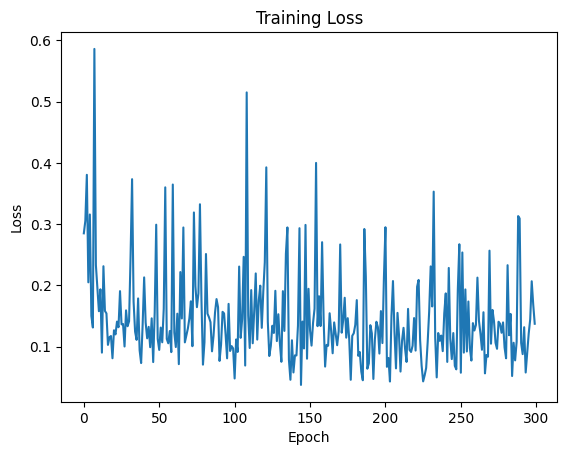

In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

losses = []
model.train()
for epoch in range(300):
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        opt_bn.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred, y)
        loss.backward()
        opt_bn.step()

    losses.append(loss.item())
    print(f"Epoch: {epoch}, Loss: {loss.item()}")

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [44]:
model.eval()
y_pred_list = []
y_true_list = []

with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        y_pred_classes = torch.argmax(y_pred, dim=1)

        y_pred_list.extend(y_pred_classes.cpu().numpy().tolist())
        y_true_list.extend(y.cpu().numpy().tolist())

correct_predictions = sum([1 for i in range(len(y_pred_list)) if y_pred_list[i] == y_true_list[i]])
accuracy = (correct_predictions / len(y_pred_list)) * 100

print(f"Classification accuracy: {accuracy:.2f}%")


Classification accuracy: 72.00%
